# Drought Event Tracking

a. stein 7.8.2022

A useful piece of information would be how big different droughts get because each pixel is impacted by its neighbor. Through blob tracking, I might be able to detect different drought events and their areas over time as they come and go.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


Load in data

In [4]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

spi_intervals = ['14d', '30d', '90d', '180d', '270d', '1y', '2y', '5y', ]
cats = ['neutral_wet', 'D0', 'D1', 'D2', 'D3', 'D4']

dm_vars = ['USDM']
dm_vars.extend([f'spi_{interval}' for interval in spi_intervals])

paired_ds = xr.open_dataset(f'{dm_path}/ndrought_products/paired_USDM_SPI.nc')

In [5]:
paired_ds

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
Data variables:
    spatial_ref  int64 ...
    USDM         (index, lat, lon) float64 ...
    USDM Date    (index) datetime64[ns] ...
    spi_1y       (index, lat, lon) float32 ...
    spi_2y       (index, lat, lon) float32 ...
    spi_5y       (index, lat, lon) float32 ...
    spi_14d      (index, lat, lon) float32 ...
    spi_30d      (index, lat, lon) float32 ...
    spi_90d      (index, lat, lon) float32 ...
    spi_180d     (index, lat, lon) float32 ...
    spi_270d     (index, lat, lon) float32 ...
    SPI Date     (index) datetime64[ns] ...
Attributes:
    author:       a. stein 6/8/2022
    description:  USDM and SPI matched to USDM data cutoff dates, as describe...
    USDM Date:    this contains the original dates for USDM
    SPI Date:     this contains the original dates for SPI

The most useful package for this appears to OpenCV .. here's a tutorial: https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/

In [2]:
import cv2

In [217]:
test = paired_ds['USDM']
test_vals = test.sel(index=500).values

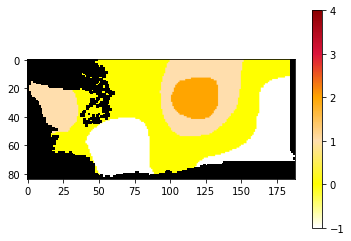

In [219]:
fig, ax = plt.subplots()

cb = ax.imshow(test_vals, vmin=-1, vmax=4, cmap=ndplot.usdm_cmap())
fig.colorbar(cb)
ax.set_facecolor('k')

Okay, I know I'm going to needs to use a binary image, so let's go ahead and use a threshold of D1

In [220]:
test_vals[test_vals < 1] = 0
test_vals[test_vals > 0] = 1

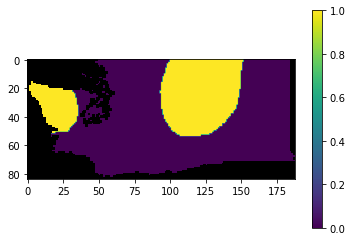

In [221]:
fig, ax = plt.subplots()

cb = ax.imshow(test_vals, vmin=0, vmax=1, cmap='viridis')
fig.colorbar(cb)
ax.set_facecolor('k')

Cool, that looks right.

Now to figure out how to make it an image ... https://www.codespeedy.com/convert-a-numpy-array-to-image-in-python/

In [222]:
from PIL import Image

In [223]:
test_vals.shape

(84, 188)

In [224]:
w, h = len(paired_ds.lon), len(paired_ds.lat)
t = (h, w, 3)
A = np.zeros(t, dtype=np.uint8)
for i in range(h):
    for j in range(w):
        val = test_vals[i,j]
        if np.isnan(val):
            val = 0
        color_val = 255*val
        color_val = np.uint8(color_val)
        #print(color_val)
        
        A[i,j]=[color_val, color_val, color_val]

img = Image.fromarray(A, 'RGB')

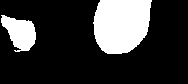

In [225]:
img

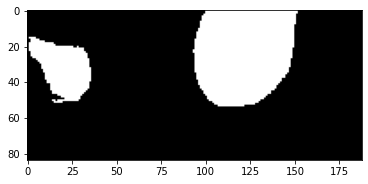

In [226]:
# double check that's right
fig, ax = plt.subplots()

ax.imshow(A, vmin=0, vmax=256)


Cool. After much debugging, that's solved.

In [227]:
gray = cv2.cvtColor(A, cv2.COLOR_RGB2GRAY)

In [228]:
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

In [229]:
output = cv2.connectedComponentsWithStats(thresh, 8, cv2.CV_32S)

In [230]:
(numLabels, labels, stats, centroids) = output

In [231]:
numLabels

2

In [232]:
labels

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

In [233]:
# so this is the bounding box and then the area in pixels
stats

array([[    1,     0,   151,    54,  3444],
       [    0,     0,   188,    84, 12348]], dtype=int32)

In [234]:
centroids

array([[96.97067364, 26.10481998],
       [92.53198899, 45.79389375]])

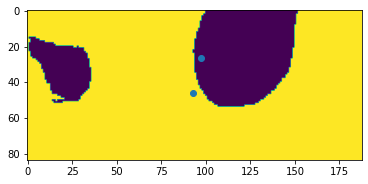

In [235]:
fig, ax = plt.subplots()

ax.imshow(labels)
ax.scatter(x=centroids[:,0], y=centroids[:,1])

In [236]:
stats[:,-1].sum()

15792

Ah, so it separated it into drought and not drought ... which isn't really what I was hoping for ...

### Scikit

Okay, this already looks soo much easier to use: https://towardsdatascience.com/image-processing-with-python-blob-detection-using-scikit-image-5df9a8380ade

In [243]:
import skimage

from skimage.io import imshow
from skimage.color import rgb2gray
from skimage.measure import label, regionprops, regionprops_table


In [248]:
label?

Signature: label(label_image, background=None, return_num=False, connectivity=None)
Docstring:
Label connected regions of an integer array.

Two pixels are connected when they are neighbors and have the same value.
In 2D, they can be neighbors either in a 1- or 2-connected sense.
The value refers to the maximum number of orthogonal hops to consider a
pixel/voxel a neighbor::

  1-connectivity     2-connectivity     diagonal connection close-up

       [ ]           [ ]  [ ]  [ ]             [ ]
        |               \  |  /                 |  <- hop 2
  [ ]--[x]--[ ]      [ ]--[x]--[ ]        [x]--[ ]
        |               /  |  \             hop 1
       [ ]           [ ]  [ ]  [ ]

Parameters
----------
label_image : ndarray of dtype int
    Image to label.
background : int, optional
    Consider all pixels with this value as background pixels, and label
    them as 0. By default, 0-valued pixels are considered as background
    pixels.
return_num : bool, optional
    Whether to 

In [250]:
regionprops_table?

Signature:
regionprops_table(
    label_image,
    intensity_image=None,
    properties=('label', 'bbox'),
    *,
    cache=True,
    separator='-',
    extra_properties=None,
)
Docstring:
Compute image properties and return them as a pandas-compatible table.

The table is a dictionary mapping column names to value arrays. See Notes
section below for details.

.. versionadded:: 0.16

Parameters
----------
label_image : (N, M[, P]) ndarray
    Labeled input image. Labels with value 0 are ignored.
intensity_image : (M, N[, P][, C]) ndarray, optional
    Intensity (i.e., input) image with same size as labeled image, plus
    optionally an extra dimension for multichannel data. Currently,
    this extra channel dimension, if present, must be the last axis.
    Default is None.

    .. versionchanged:: 0.18.0
        The ability to provide an extra dimension for channels was added.
properties : tuple or list of str, optional
    Properties that will be included in the resulting dictionary
 

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


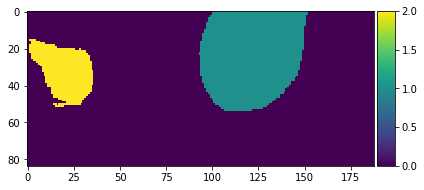

In [249]:
blobs = label(rgb2gray(A) > 0, connectivity=2)
imshow(blobs)

YAY! DIFFERENT BLOBS

List of all different properties: https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops

In [246]:
properties =['area','bbox','convex_area','bbox_area',
             'major_axis_length', 'minor_axis_length',
             'eccentricity']
df = pd.DataFrame(regionprops_table(blobs, properties = properties))

In [247]:
df

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,bbox_area,major_axis_length,minor_axis_length,eccentricity
0,2631,0,93,54,152,2685,3186,63.273580,54.261958,0.514356
1,813,15,1,52,36,933,1295,41.588572,27.159956,0.757304


let's put that in a nicer function

In [253]:
(h, w) = test_vals.shape
h, w

(84, 188)

In [275]:
from shapely.geometry import Polygon

In [329]:
def identify_drought_blob(vals:np.ndarray):

    # first we're going to make this binary
    # by setting data in a drought to 1 and
    # not in a drought to 0, including nan

    vals[(vals < 1) | np.isnan(vals)] = 0
    vals[vals > 0] = 1

    # now we are going to convert to RGB
    (h, w) = vals.shape
    t = (h, w, 3)
    A = np.zeros(t, dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            # since we already made it binary, this
            # will make 1 vals be white and 0 vals
            # be black in our RGB array
            color_val = 255*vals[i,j]
            A[i, j] = [color_val, color_val, color_val]

    # connectivity 2 will consider diagonals as connected
    blobs = label(rgb2gray(A) > 0, connectivity=2)

    properties =['area','bbox','convex_area','coords']
    df = pd.DataFrame(regionprops_table(blobs, properties=properties))

    return df

    poly_geos = []
    for coords in df.coords.values:
        poly_geos.append(Polygon(zip(coords[:,1], coords[:,0])))    

    return gpd.GeoDataFrame(df[['area']], geometry = poly_geos)

In [330]:
blobs = identify_drought_blob(test_vals)
blobs

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,coords
0,2631,0,93,54,152,2685,"[[0, 100], [0, 101], [0, 102], [0, 103], [0, 1..."
1,813,15,1,52,36,933,"[[15, 1], [15, 2], [15, 3], [15, 4], [16, 2], ..."


In [331]:
blob_x = blobs.coords.values[0][:,1]
blob_y = blobs.coords.values[0][:,0]

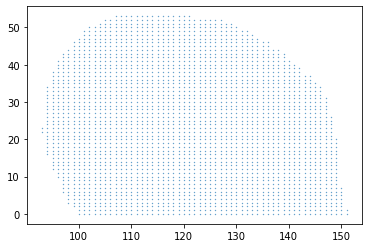

In [333]:
fig, ax = plt.subplots()

ax.scatter(blob_x, blob_y, s=0.1)

OH. That's why my conversion to Polygon keeps looking funky. `coords` gets all the pixels that are in the blob

Actually the easiest solution to detecting if they are the same via overlap is to see if they share any of the same pixels. Now this won't handle something diverging, but it's a start.

Let's test that

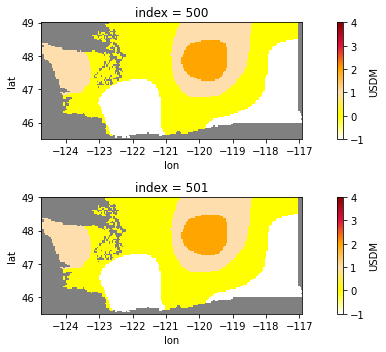

In [343]:
fig, axs = plt.subplots(2,1, figsize=(10,5))

for ax, idx in zip(axs.ravel(), [500, 501]):
    test.sel(index=idx).plot(ax=ax, vmin=-1, vmax=4, cmap=ndplot.usdm_cmap())
    ax.set_facecolor('gray')
    ax.set_aspect('equal')

plt.tight_layout()

Cool, those are pretty similar and will suffice

In [345]:
blobs_i500 = identify_drought_blob(test.sel(index=500).values)
blobs_i500

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,coords
0,2631,0,93,54,152,2685,"[[0, 100], [0, 101], [0, 102], [0, 103], [0, 1..."
1,813,15,1,52,36,933,"[[15, 1], [15, 2], [15, 3], [15, 4], [16, 2], ..."


In [347]:
blobs_i501 = identify_drought_blob(test.sel(index=501).values)
blobs_i501

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,coords
0,2631,0,93,54,152,2685,"[[0, 100], [0, 101], [0, 102], [0, 103], [0, 1..."
1,813,15,1,52,36,933,"[[15, 1], [15, 2], [15, 3], [15, 4], [16, 2], ..."


In [352]:
np.intersect1d(blobs_i501.coords.values[0], blobs_i500.coords.values[1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [367]:
blob_dict = dict()

for a, coords_i501 in enumerate(blobs_i501.coords.values):
    coords_i501_set = set(tuple(coord) for coord in coords_i501)
    for b, coords_i500 in enumerate(blobs_i500.coords.values):
        coords_i500_set = set(tuple(coord) for coord in coords_i500)
        if len(coords_i501_set.intersection(coords_i500_set)) > 0:
            blob_dict[a] = b

In [368]:
blob_dict

{0: 0, 1: 1}

Awesome. I'm not sure the efficiency of that solution but it's a solution

Now how would we handle blobs splitting into new blobs or joining into one blob ...